# Building a link between the clothing and the shoes

In [1]:
import os
import numpy as np
import random
from loading import load_files

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
# get all files for a provided path
def get_paths(path):
    data = load_files(path, ignore_files='.DS_Store')
    clothing_files = np.array(data['filenames'])
    return clothing_files

In [19]:
# get all files for specific paths
def specific_paths(cloth_cat, shoe_cat):
    all_cloth_paths = []
    cloth_path = '../data/clothing2/' + cloth_cat
    cloth_files = os.listdir(cloth_path)
    for file in cloth_files:
        all_cloth_paths.append(cloth_path + file)
        
    all_shoe_paths = []
    shoe_path = '../data/shoes/' + shoe_cat
    shoe_files = os.listdir(shoe_path)
    for file in shoe_files:
        all_shoe_paths.append(shoe_path + file)    
    return all_cloth_paths, all_shoe_paths

In [11227]:
clothing_train, shoe_train = specific_paths('train/red_short_dresses/', 'train/heels/')
clothing_test, shoe_test = specific_paths('test/red_short_dresses/', 'test/heels/')
clothing_valid, shoe_valid = specific_paths('validate/red_short_dresses/', 'validate/heels/')
clothing = clothing_train + clothing_test + clothing_valid
shoes = shoe_train + shoe_test + shoe_valid
print(len(clothing), len(shoes))


266 5602


In [11228]:
# clothing_train, shoe_train2 = specific_paths('train/red_short_dresses/', 'train/flats/')
# clothing_test, shoe_train3 = specific_paths('test/red_short_dresses/', 'validate/flats/')
clothing_valid, shoe_train4 = specific_paths('validate/red_short_dresses/', 'train/sandals/')
clothing_valid, shoe_train5 = specific_paths('validate/red_short_dresses/', 'validate/sandals/')
clothing = clothing_train + clothing_test + clothing_valid
shoes += shoe_train4 + shoe_train5 #+ shoe_train4 + shoe_train5
print(len(clothing), len(shoes))


266 9556


In [23]:
# # get ALL paths to clothing in one list
# clothing_paths = []
# root = '../data/clothing2/'
# folders = ['train', 'validate', 'test']

# for folder in folders:
#     clothing_paths += list(get_paths(root + folder))
    
# print(len(clothing_paths))
# clothing_paths[:5]

In [24]:
# # get ALL paths to shoes in one list
# shoe_paths = []
# root = '../data/shoes/'
# folders = ['train', 'validate', 'test']

# for folder in folders:
#     shoe_paths += list(get_paths(root + folder))
    
# print(len(shoe_paths))
# shoe_paths[:5]

In [27]:
def view_images(path1, path2):
    plt.figure(figsize=(10,10))

    plt.subplot(1,2,1)
    im = mpimg.imread(path1)
    plt.imshow(im);
    plt.title('Clothing Item')
    plt.axis('off')

    plt.subplot(1,2,2)
    im = mpimg.imread(path2)
    plt.imshow(im);
    plt.title('Shoe Item')
    plt.axis('off');

In [ ]:
# # def mark_file(path_list1, path_list2, file):     
# rand_clothing_path = random.sample(clothing_paths, 1)[0]
# rand_shoe_path = random.sample(shoe_paths, 1)[0]
# view_images(rand_clothing_path, rand_shoe_path)

In [12433]:
i = 238

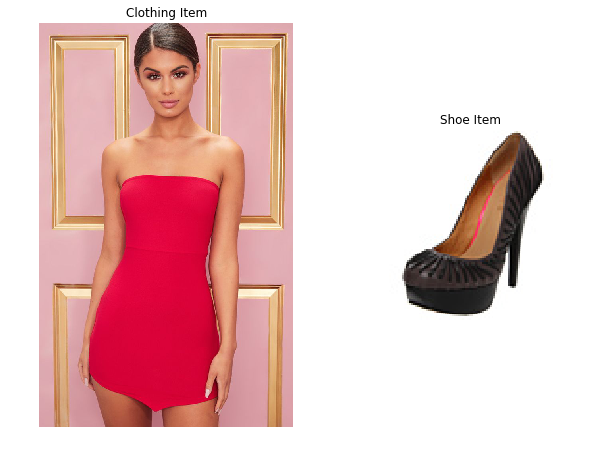

In [12631]:
path1 = clothing[i]
path2 = random.sample(shoes, 1)[0]
view_images(path1, path2)

In [12630]:
response = input()
if response == '1':
    i += 1
file = open('../data/links.txt','a') 
file.write(f'{path1}, {path2}, {response}') 
file.write('\n')
file.close()

0


In [12432]:
i

237

In [11835]:
import pandas as pd
df = pd.read_csv('../data/links.txt')

In [11836]:
print(df.shape)
df.head()

(5335, 3)


,clothing_path,shoe_path,response
0,../data/clothing2/train/black_short_dresses/bl...,../data/shoes/train/heels/8113201.69035.jpg,0
1,../data/clothing2/train/light_blue_short_dress...,../data/shoes/train/athletic/8140605.151.jpg,0
2,../data/clothing2/train/brown_suede_jackets/br...,../data/shoes/train/knee_boots/7347958.281.jpg,0
3,../data/clothing2/validate/long_sleeve_tops/lo...,../data/shoes/train/ankle_boots/8112971.72.jpg,1
4,../data/clothing2/train/white_pants/white_pant...,../data/shoes/test/sandals/7505095.6.jpg,1


In [11837]:
df['response'].value_counts()

 0    3800
 1    1507
 q       1
 -       1
 !       1
Name: response, dtype: int64